In [12]:
import torch 
import torch.nn as nn
import requests
import zipfile
from pathlib import Path
import os 
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Setup the Dataset


In [6]:
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    image_path.mkdir(parents=True,exist_ok=True)
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip",'w') as zf:
        request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip")

data\pizza_steak_sushi already exists


### Data exploration 


In [9]:
def walk_through_dir(dir_path):
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} directors and {len(filenames)} files in {dirpath}")

walk_through_dir(image_path)

there are 2 directors and 0 files in data\pizza_steak_sushi
there are 3 directors and 0 files in data\pizza_steak_sushi\test
there are 0 directors and 25 files in data\pizza_steak_sushi\test\pizza
there are 0 directors and 19 files in data\pizza_steak_sushi\test\steak
there are 0 directors and 31 files in data\pizza_steak_sushi\test\sushi
there are 3 directors and 0 files in data\pizza_steak_sushi\train
there are 0 directors and 78 files in data\pizza_steak_sushi\train\pizza
there are 0 directors and 75 files in data\pizza_steak_sushi\train\steak
there are 0 directors and 72 files in data\pizza_steak_sushi\train\sushi


### Setup training and test path 


In [10]:
train_dir= image_path /"train"
test_dir= image_path /"test"    
print(f"there are {len(os.listdir(train_dir))} classes in the training directory")
print(f"there are {len(os.listdir(test_dir))} classes in the test directory")

there are 3 classes in the training directory
there are 3 classes in the test directory


### Visualize the data 

random image path:data\pizza_steak_sushi\test\sushi\2394442.jpg and class is :sushi


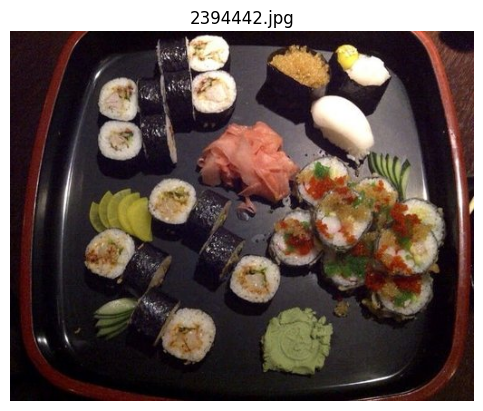

 random image path : data\pizza_steak_sushi\test\sushi\2394442.jpg and class is : sushi


In [24]:
random .seed(42)
#get a random image path
image_path_list=list(image_path.glob("*/*/*.jpg"))
#print(image_path_list)
random_image_path=random.choice(image_path_list)
image_class=random_image_path.parent.stem
print(f"random image path:{random_image_path} and class is :{image_class}")
#open the image and plot it
img=Image.open(random_image_path)   
#print(img)
plt.imshow(img)
plt.axis(False)
plt.title(random_image_path.name)
plt.show()
print (f" random image path : {random_image_path} and class is : {image_class}")
